In [87]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'

from PIL import Image

import pandas as pd

import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
rooms_set = {"DINING ROOM", "KITCHEN", "LIVING ROOM", 
             "BEDROOM 1", "BEDROOM 2", "BEDROOM 3", "BEDROOM 4", "GARAGE", 
             "MASTER BEDROOM", "SITTING ROOM", "UTILITY", "CONSERVATORY", "RECEPTION ROOM", "GARDEN",
            "STUDY"}

In [32]:
room_side_regex = r'[0-9]+[.][0-9]+'

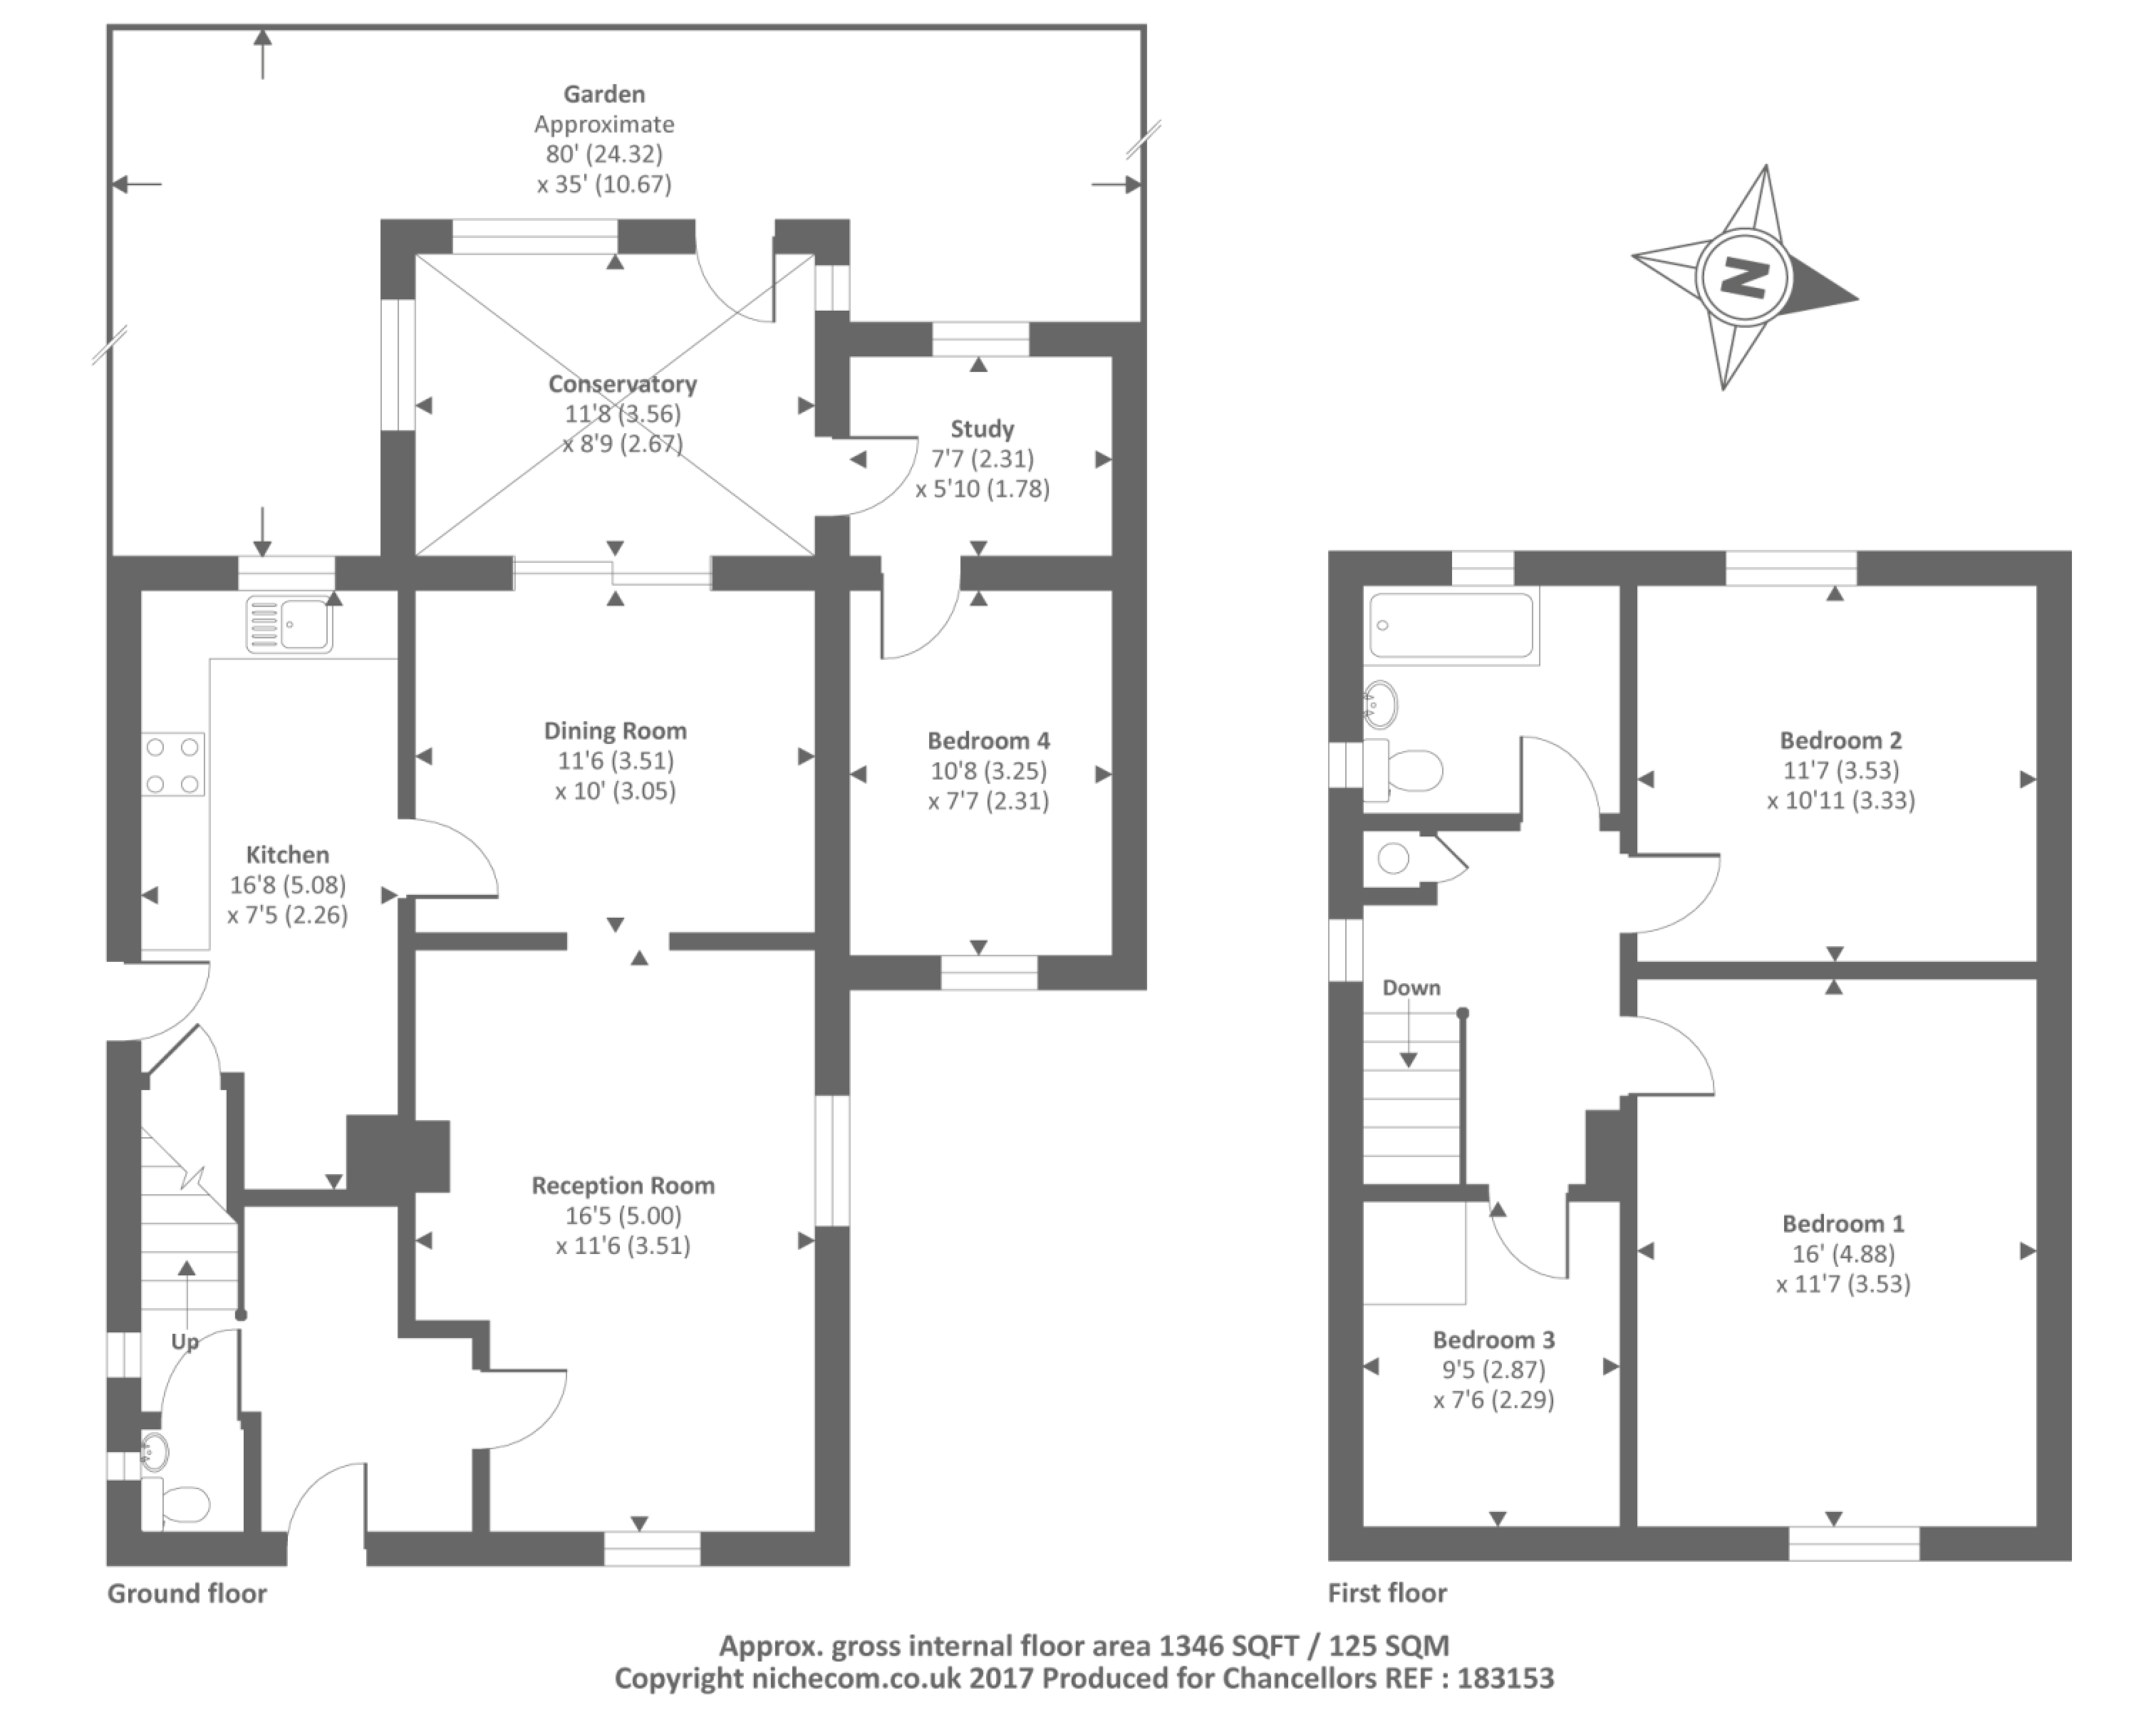

In [4]:
image = Image.open('plans/floorplan_04.png')
image = image.resize((image.size[0] * 3, image.size[1] * 3))
image

In [66]:
df = pytesseract.image_to_data(image, output_type='data.frame')
df = df[df['conf'] != -1]
df['text'] = df['text'].apply(lambda x: x.strip())
df = df[df['text']!=""]
df['text'] = df['text'].apply(lambda x: x.upper())

In [67]:
df['block_num'].value_counts()

25    19
6     10
22     7
21     7
20     7
18     7
11     7
9      7
2      7
14     6
7      6
24     2
19     2
Name: block_num, dtype: int64

In [68]:
# might be spanning over multiple rows 
shifted_text_col = list(df['text'].iloc[1:])
shifted_text_col.append("")
df['text_2row'] = df['text'] + " " + shifted_text_col

In [69]:
df['class'] = ""
df['side_number'] = ""

In [70]:
class_list = []
i = 0
while i < len(df):
    curr_class = ""
    
    if df['text_2row'].iloc[i] in rooms_set:
        curr_class = "room"
        class_list.append(curr_class)
        df['text'].iloc[i] = df['text_2row'].iloc[i]
        i += 1
        curr_class = "DEL"
        class_list.append(curr_class)
        i += 1 # find this more readable this way
    elif df['text'].iloc[i] in rooms_set:
        curr_class = "room"
        class_list.append(curr_class)
        i += 1
    
    if curr_class == "":
        regex_list = re.findall(room_side_regex,df['text'].iloc[i])
        if len(regex_list) > 0:
            curr_class = "room_side"
            df['side_number'].iloc[i] = float(regex_list[0])
            class_list.append(curr_class)
            i += 1
    
    if curr_class == "":
        class_list.append(curr_class)
        i += 1
        
df['class'] = class_list

In [71]:
df = df[(df['class'] != "") & (df['class'] != "DEL")]

In [79]:
df['value'] = ""
df['value'][df['class']=="room"] = df['text']
df['value'][df['class']=="room_side"] = df['side_number']
df.drop(['text', 'text_2row', 'side_number'], inplace = True, axis = 1)

In [80]:
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,class,value
18,5,1,2,1,1,1,1188,177,168,39,96,room,GARDEN
23,5,1,2,1,3,2,1236,303,156,48,95,room_side,24.32
27,5,1,2,1,4,3,1254,366,159,48,96,room_side,10.67
53,5,1,6,1,2,1,1158,786,309,57,95,room,CONSERVATORY
55,5,1,6,1,3,1,1194,840,237,60,0,room_side,3.56
58,5,1,6,1,4,2,1308,909,144,63,74,room_side,2.67
59,5,1,6,1,4,3,2004,882,132,48,96,room,STUDY
65,5,1,7,1,1,3,1962,945,213,48,43,room_side,2.31
69,5,1,7,1,2,3,2082,1008,126,48,96,room_side,1.78
84,5,1,9,1,1,1,1149,1518,147,48,96,room,DINING ROOM


We select the ones that are closest for each room. Euclidean distance of upper left corner. 

In [86]:
df_rooms = df[['left', 'top', 'value']][df['class'] == "room"]
df_sides = df[['left', 'top', 'value']][df['class'] == "room_side"]

In [88]:
from scipy.spatial import distance_matrix

In [91]:
dist = distance_matrix(df_rooms[['left', 'top']], df_sides[['left', 'top']])

In [102]:
df_rooms['side_a'] = ""
df_rooms['side_b'] = ""

side_a = []
side_b = []

for i in range(len(df_rooms)):
    curr_argpart = np.argpartition(dist[i],2)
    curr_side_a = df_sides['value'].iloc[curr_argpart[0]]
    curr_side_b = df_sides['value'].iloc[curr_argpart[1]]
    side_a.append(curr_side_a)
    side_b.append(curr_side_b)
    
df_rooms['side_a'] = side_a
df_rooms['side_b'] = side_b

In [107]:
df_rooms.drop(['left','top'], inplace = True, axis = 1)
df_rooms['size'] = df_rooms['side_a'] * df_rooms['side_b']

In [111]:
df_rooms.rename(columns = {"value": "room"}, inplace = True)

In [116]:
df_rooms.reset_index(inplace = True, drop = True)

In [119]:
df_rooms

,room,side_a,side_b,size
0,GARDEN,24.32,10.67,259.4944
1,CONSERVATORY,3.56,2.67,9.5052
2,STUDY,2.31,1.78,4.1118
3,DINING ROOM,3.51,3.05,10.7055
4,BEDROOM 4,3.25,2.31,7.5075
5,KITCHEN,5.08,2.26,11.4808
6,RECEPTION ROOM,5.00,3.51,17.5500
7,BEDROOM 2,3.53,3.33,11.7549
8,BEDROOM 1,4.88,3.53,17.2264
9,BEDROOM 3,2.87,2.29,6.5723
